In [109]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import math
import time
import maxflow

%matplotlib inline

In [1]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne.layers import *
import lasagne.layers.dnn

input_X = T.tensor4("X")
target_y = T.vector("Y", dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


In [192]:
H, W = 13, 13

In [193]:
images = []
masks = []
for filename in glob('pub/images/*.png'):
    images.append(plt.imread(filename))
    masks.append(plt.imread(filename.replace('images', 'gt')))

In [201]:
def prepare_data_for_nn(images, masks):
    X, y = [], []
    delta = int(math.floor(H / 2.))
    for im in range(len(images)):
#         print im
        for i in range(delta, images[im].shape[0] - delta):
            for j in range(delta, images[im].shape[1] - delta):
                X.append(images[im][i - delta: i + delta + 1, j - delta: j + delta + 1])
                y.append(masks[im][i][j])
    return np.array(X), np.array(y)

In [202]:
%time X, y = prepare_data_for_nn(images, masks)

CPU times: user 7.58 s, sys: 1.95 s, total: 9.52 s
Wall time: 9.53 s


In [203]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

In [424]:
network2 = lasagne.layers.InputLayer(shape=(None,) + (H, W) + (3,), input_var=input_X)
network2 = lasagne.layers.DimshuffleLayer(network2, (0, 3, 1, 2))
network2 = lasagne.layers.dnn.Conv2DDNNLayer(network2, 32, filter_size=(3, 3), pad='same', nonlinearity=rectify, name="conv1")
# network = lasagne.layers.Conv2DLayer(network, 32, filter_size=(3, 3), pad='same', nonlinearity=rectify, name="conv1")
network = MaxPool2DLayer(network2, pool_size=(2, 2), stride=2, name="pool1")
# network = BatchNormLayer(network, name="bn1")
network2 = lasagne.layers.dropout(network2, p=0.5)

network2 = batch_norm(lasagne.layers.dnn.Conv2DDNNLayer(network2, num_filters=64, filter_size=(2, 2), stride=1, nonlinearity=rectify, name="conv2"))
# network = lasagne.layers.Conv2DLayer(incoming=network, num_filters=64, filter_size=(2, 2), nonlinearity=rectify, name="conv2")
# network2 = lasagne.layers.dropout(network, p=0.2)

# network = lasagne.layers.dnn.Conv2DDNNLayer(incoming=network, num_filters=64, filter_size=(3, 3), pad='same', stride=1, nonlinearity=rectify, name="conv2")
# network = lasagne.layers.Conv2DLayer(incoming=network, num_filters=64, filter_size=(2, 2), pad='same', stride=1, nonlinearity=rectify, name="conv2")
# network = lasagne.layers.MaxPool2DLayer(incoming=network, pool_size=(2, 2), stride=2, pad=1, name="pool2")
# network = lasagne.layers.BatchNormLayer(incoming=network, name="bn2")

network2 = DenseLayer(incoming=network2, num_units=128, nonlinearity=rectify, name="dense1")
# network = DenseLayer(incoming=network, num_units=100, nonlinearity=rectify, name="dense1")
# network2 = BatchNormLayer(incoming=network2, name="bm_last")

network2 = DenseLayer(incoming=network2, num_units=2, nonlinearity=softmax)

In [425]:
y_predicted = lasagne.layers.get_output(network2)
all_weights = lasagne.layers.get_all_params(network2, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
loss += lasagne.regularization.regularize_network_params(network, lasagne.regularization.l2) * 2e-3
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adadelta(loss, all_weights)

In [426]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)
predict_fun = theano.function([input_X], [y_predicted], allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True)

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock


In [207]:
batch_size = 200
num_epochs = 100

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train.astype('int32'), batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 363.348s
  training loss (in-iteration):		0.137341
  train accuracy:		94.84 %
  validation accuracy:		96.19 %
Epoch 2 of 100 took 363.413s
  training loss (in-iteration):		0.100869
  train accuracy:		96.29 %
  validation accuracy:		96.59 %
Epoch 3 of 100 took 364.750s
  training loss (in-iteration):		0.090881
  train accuracy:		96.67 %
  validation accuracy:		96.94 %
Epoch 4 of 100 took 365.136s
  training loss (in-iteration):		0.085266
  train accuracy:		96.88 %
  validation accuracy:		96.94 %
Epoch 5 of 100 took 364.818s
  training loss (in-iteration):		0.081339
  train accuracy:		97.04 %
  validation accuracy:		97.07 %
Epoch 6 of 100 took 365.711s
  training loss (in-iteration):		0.078324
  train accuracy:		97.15 %
  validation accuracy:		97.14 %
Epoch 7 of 100 took 366.098s
  training loss (in-iteration):		0.075615
  train accuracy:		97.25 %
  validation accuracy:		97.33 %
Epoch 8 of 100 took 366.396s
  training loss (in-iteration):		0.073351
  train accuracy:		

KeyboardInterrupt: 

In [428]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

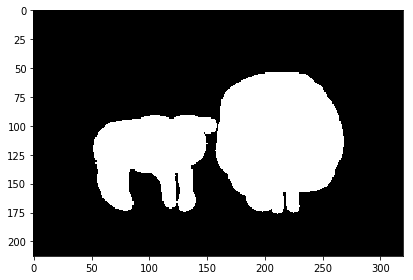

In [429]:
io.imshow(masks[15])

In [432]:
mask = predict(images[15], network, input_X)
mask2 = segmentation(images[15], mask, 30, 15)

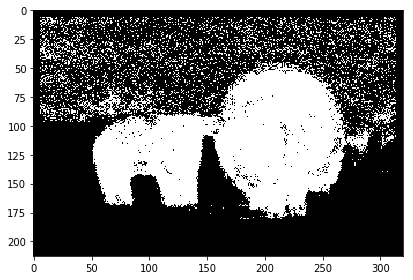

In [433]:
io.imshow(mask)


/home/ubuntu/env/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


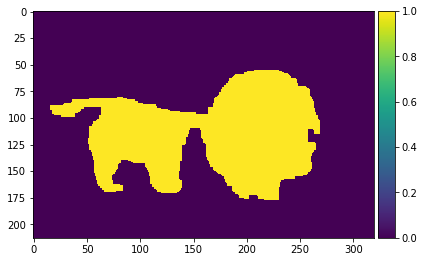

In [262]:
io.imshow(mask2)

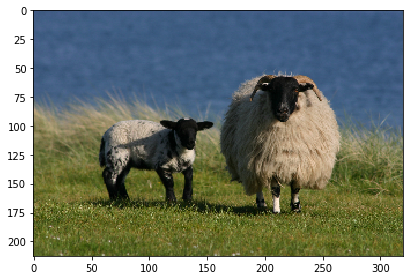

In [254]:
io.imshow(images[15])

In [24]:
X.shape

(4029480, 9, 9, 3)

In [16]:
import time

def train_unary_model(num_epochs=10, batch_size = 250):
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))

        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(
            train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))


In [142]:
def predict(image, network, input_X):
    X = []
    delta = int(math.floor(H / 2.))
    for i in range(delta, image.shape[0] - delta):
        for j in range(delta, image.shape[1] - delta):
            X.append(image[i - delta: i + delta + 1, j - delta: j + delta + 1])
    
    y_pred = np.array(predict_fun(X))[0]
    y_pred = np.array([np.argmax(i) for i in y_pred]).reshape((image.shape[0] - delta * 2, image.shape[1] - delta * 2))
    
    mask = np.zeros((image.shape[0], image.shape[1]))
    for i in range(delta, image.shape[0] - delta):
        for j in range(delta, image.shape[1] - delta):
            mask[i, j] = y_pred[i - delta, j - delta]
#     for i in range(delta)[::-1]:
#         for j in range(image.shape[1]):
#             if mask[i + 1, j] == 1:
#                 mask[i, j] = 1
#             if mask[image.shape[0] - i - 2, j] == 1:
#                 mask[image.shape[0] - i - 1, j] = 1
#     for i in range(image.shape[0]):
#         for j in range(delta)[::-1]:
#             if mask[i, j+ 1] == 1:
#                 mask[i, j] = 1
#             if mask[i, image.shape[0] - j - 2] == 1:
#                 mask[i, image.shape[0] - j - 1] = 1
    return mask

In [383]:
X_test = []
for filename in glob('images/*.png'):
    X_test.append(plt.imread(filename))

In [385]:
unary_masks = []
for im in X_test:
    unary_masks.append(predict(im, network, input_X))

In [188]:
def segmentation(img, mask, A=0, B=1, sigma=1):
    g = maxflow.Graph[float](np.prod(mask.shape), np.prod(mask.shape) * 4)
    nodes = g.add_nodes(np.prod(mask.shape))
    positions = [(1,0), (-1,0), (0,1), (0,-1)]
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            node1 = nodes[i * mask.shape[1] + j]
            g.add_tedge(node1, -math.log(mask[i, j]), -math.log(1 - mask[i, j]))
            for k, l in positions:
                if 0 <= i + k < mask.shape[0] and 0 <= j + l < mask.shape[1]:
                    node2 = nodes[(i + k) * mask.shape[1] + j + l]
                    magnitude = A + B * np.exp(-np.linalg.norm(img[i, j] - img[i + k, j + l]) ** 2 / 2 * sigma ** 2)
                    g.add_edge(node1, node2, magnitude / 2, magnitude / 2)
    flow = g.maxflow()
    res = np.zeros(mask.shape, np.int)
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i,j] = g.get_segment(nodes[i * res.shape[1] + j])
    return res

In [442]:
lol = segmentation(X_test[7], unary_masks[7], A=20, B=15)

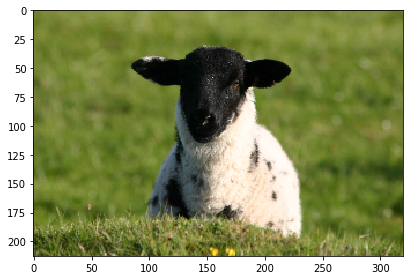

In [441]:
io.imshow(X_test[7])

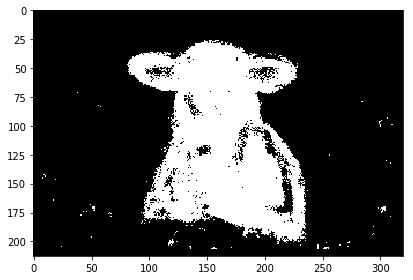

In [443]:
io.imshow(unary_masks[7])

/home/ubuntu/env/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


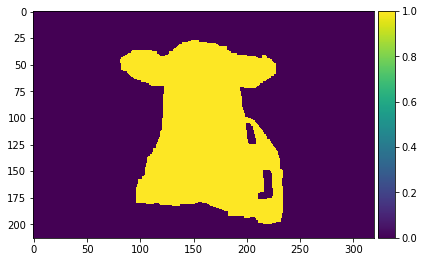

In [444]:
io.imshow(lol)

In [413]:
from itertools import chain
def run_length_enc(label):
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [450]:
with open('res5.csv', 'w') as f:
    f.write('img,pixels\n')
    for filename in glob('images/*.png'):
        image = plt.imread(filename)
        mask = predict(image, network, input_X)
        mask = segmentation(image, mask, 20, 15)
        f.write(filename[7:] + ',')
        f.write(run_length_enc(mask))
        f.write('\n')